# Assignment 1 
Collaborators (Name, study id, github handle): <br />
August Hertz Bugge - s194350 - libze<br />
David Bro Ludvigsen - s204102 - davidAlvaBro<br />
Sebastian Nicolai Fabricius Grut  - s204150 - Sebastiannfg

Github : https://github.com/davidAlvaBro/comsocsci2023.git 

#### Contributions 
We collaborated as a group. We have had weekly meetings where we completed the weekly assignments together - everything has been discussed and made together. 


#### Note to reader 
We found it helpfull to make the exercises as scripts for the different weeks, so that it is easier to run on a new device. The scripts used can be found in this github aswell and are the reason that much of our code is seperated into functions. 


In [1]:
# Setup - all imports 
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import urllib3
import time
import numpy as np
import os 
import matplotlib.pyplot as plt 

## Webscraping (week 1)

### Code - Webscraping 

In [2]:
# This code was needed to run on certain devices / disables certain warnings that will stop the script
def disable_warnings():
    requests.packages.urllib3.disable_warnings()
    requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += ':HIGH:!DH:!aNULL'
    try:
        requests.packages.urllib3.contrib.pyopenssl.util.ssl_.DEFAULT_CIPHERS += ':HIGH:!DH:!aNULL'
    except AttributeError:
    # no pyopenssl support used / needed / available
        pass
    

In [3]:
# 2019 posters 
def get_2019_posters(verbose=False):
    """
    Get all names from the webpage : https://2019.ic2s2.org/posters/
    
    Returns:
        set: A set of all unique names occuring in the page
    """
    # Get the webpage data
    LINK = "https://2019.ic2s2.org/posters/"
    r = requests.get(LINK)
    soup = BeautifulSoup(r.content, features="html.parser")

    # Get each bullet point under class "col-md-8" (all the names are here)
    text = soup.find("div", {"class": "col-md-8"})
    items = text.find_all("li")
    item_list = [str(item) for item in items]

    # Get content between > and <, and seperate at , 
    regex_compiler = re.compile("(?<=\>)(.*?)(?=\<)")

    names = [regex_compiler.findall(item)[0] for item in item_list]
    ind_names = [re.split(', | and', name) for name in names]
    persons =  []
    
    # Collect to one list
    for list in ind_names:
        for name in list:
            persons.append(name)

    # Verbose 
    people_set = set(persons)
    if verbose: print(f"There are {len(people_set)} different people and {len(persons)} name occurences in {LINK}")
    return people_set


In [4]:
# 2019 oral presentations 
def get_2019_oral(verbose=False):
    """
    Get all names from the webpage : https://2019.ic2s2.org/oral-presentations/
    
    Returns:
        set: A set of all unique names occuring in the page
    """
    def find_between( string, first, last ):
        """
        Returns the part of a string that is in the middel of first and last (substrings)

        Args:
            string (String): The string
            first (String): the start "token"
            last (String): the end "token"

        Returns:
            _type_: Substring between "first" and "last"
        """
        try:
            start = string.index( first ) + len( first )
            end = string.index( last, start )
            return string[start:end]
        except ValueError:
            return ""
    
    # Get the webpage data
    LINK = "https://2019.ic2s2.org/oral-presentations/"
    r = requests.get(LINK)
    soup = BeautifulSoup(r.content) 
    
    # All names are between these two titles as a string 
    soup_string = find_between(str(soup),"1A Misinformation","Evidence of Influence Hierarchies in GitHub’s Cryptocurrency Community" ).split("<p>")# each <p> has it's own section with a chairname and a list of presenters
    
    # form a new list of the unfiltered remaining names 
    new_list = []
    for d in soup_string:
        new_list.append(find_between(d,"</em><br/>","</p>"))
    
    newer_list = []
    #Remove known non-name including files
    for i in range(20): 
        current_line = new_list[i].split("<br/>")
        for x in current_line:
            x = x[16:]
            if str(x) == "No Presentation":
                pass
            else:
                newer_list.append(x)
    
    # Seperate into two schools - the ones that end with .  and the ones with - 
    # Seperate names at , and remove empty names. 
    # If there is a : then it is not a name, only take what is after. Exceptions like these are due to the format of the html soup
    names_list = []
    for i in newer_list:
        if str(i[-1]) == "–":
            x = str(i[:-2]).split(",")
            for m in x:
                if m != "":
                    if ":" in m:
                        m = m[m.find(":")+1:]
                    names_list.append(m)
        else:
            imp_ful = 0
            for E in range(len(i)):
                if i[E] == "." and i[E-2] != " ":
                    imp_ful = E
                    break
            namees = i[:imp_ful].split(",")
            for O in namees:
                if O != "":
                    if ":" in O:
                        O = O[O.find(":")+2:]
                    names_list.append(O)
    
    # Delete "No presentation (cancelled)" entries 
    for i in range(len(names_list)):
        if names_list[i-1] == "No presentation (cancelled)":
            names_list.pop(i-1)
    
    
    ## Get the chair names 
    # These are uniquely seperated, as they are always in the same place, seperate of the other author names.
    chair_names = []
    for i in soup_string:
        chair_names.append(find_between(i, "Chair:", "</em>"))
    
    ### Merge the two lists 
    final_list = []
    for i in names_list+chair_names:
        if i[0] == " ":
            final_list.append(i[1:])
        else:
            final_list.append(i)
        
    return set(final_list)

In [5]:
# 2020 
def get_2020_all(verbose=False):
    """
    Get all names from the webpage : "https://ic2s2.mit.edu/program"
    
    Returns:
        set: A set of all unique names occuring in the page
    """
    # Get page content 
    LINK = "https://ic2s2.mit.edu/program"
    req = requests.get(LINK, verify= False)
    soup = BeautifulSoup(req.content, features="html.parser")
    
    # Scrape link to the page with the actuel content
    text = soup.find("div", {"class": "article-content"})
    str_text = str(text).split("src=")
    docs_link = str_text[-1].split(" ")[0][1:-1]
    
    # All names are stored in the table in the class "waffle" 
    r = requests.get(docs_link)
    soup = BeautifulSoup(r.content, features="html.parser")
    table = soup.find("table", {"class": "waffle"})
    table_rows = table.find_all("tr") # Get all rows 
    
    # Go through each row and put the data into a list (row of dataframe)
    rows = []
    for tr in table_rows[1:]:
        tds = tr.find_all('td')
        row = [td.text.replace("\n","") for td in tds]
        rows.append(row)
    
    # Make the dataframe 
    df = pd.DataFrame(rows)#, columns=header[0:5])
    # Extract names from column 2 (zero indexed) starting from the 1 (zero indexed) element
    names_plus = [name.split(', ') for name in list(df.iloc[:,2][1:])]
    names = []
    for name in names_plus:
        for n in name:
            if len(n) :
                names.append(n)
    if verbose: f"There are {len(set(names))} different people and {len(names)} name occurences in {LINK}"
    return list(set(names))


In [6]:
# 2021 
def get_2021_all(verbose=False): 
    """
    Get all names from the webpage : "https://easychair.org/smart-program/IC2S2-2021/talk_author_index.html"
    
    Returns:
        set: A set of all unique names occuring in the page
    """
    # Get page content 
    LINK = "https://easychair.org/smart-program/IC2S2-2021/talk_author_index.html"
    request = requests.get(LINK)
    soup = BeautifulSoup(request.content)
    
    # All names are in the table "index" and we split at "tr"; each containing one name
    contents = soup.find("table", "index")
    contents = contents.find_all("tr")
    
    # Regex compiler that finds elements between > < (not including)
    regex_compiler = re.compile("\>(.*?)\<")
    names = set()
    counter = 0
    
    # Go through each tr (statement) and split at each td find the first name and surname
    for content in contents: 
        person = str(content.find_all("td")[0])
        titles = regex_compiler.findall(person)[2:-1]
        if len(titles) == 2: # There is not exactly two elements it is not a name (but a Alphabetic code)
            name = titles[1] + " " + titles[0]
            name = name.replace(",", "")
            name = name.strip()
            
            names.add(name) 
            counter +=1

    if verbose: f"There are {len(names)} different people and {counter} name occurences in {LINK}"
    return names


In [7]:
# Helper functions, as the datasets will need to be stored underway as they are very large
def save_data(data, file_name): 
    """
    A function to save a dictionary (or set) 

    Args:
        ids (data): data/set that needs to be stored
        file_name (str): file name 
    """
    np.save(f"{file_name}.npy", data)

def load_data(file_name):
    """
    Loads a data object (dict or set) 

    Args:
        file_name (str): file_name (without prefix)
    Returns:
        set or dict: data in the file
    """
    
    data = np.load(f"{file_name}.npy", allow_pickle=True).item()
    
    return data


In [8]:
# Scrape data from all three years 
def get_all_names(verbose=False, Body = False):
    """
    Collects all four datasets's names into one set 

    Args:
        verbose (bool, optional): True -> prints comments about how many times names appear and how many there are
    """
    if Body: disable_warnings()

    # Run the previous four methods
    names_2019_poster = get_2019_posters(verbose)
    names_2019_oral = get_2019_oral(verbose)
    names_2020_all = get_2020_all(verbose)
    names_2021_all = get_2021_all(verbose)
    
    # Collect into one set
    names_all = set()
    names_all.update(names_2019_poster, names_2019_oral, names_2020_all, names_2021_all)
    
    if verbose: print(f"There are {len(get_all_names())} unique names in total")
    return names_all

# To not repeat this time consuming process we save the results and load them if possible
science_people_file_name = "names_week_1"
if os.path.isfile(science_people_file_name + ".npy"):
    science_people = load_data(science_people_file_name)
else: 
    science_people = get_all_names()
    save_data(science_people, science_people_file_name)

print(f"In total we have {len(science_people)} unique computational social scientists across the three years")

In total we have 2133 unique computational social scientists across the three years


In [9]:
# How many unique authors are there in 2019 split across oral and poster? 
authors_oral_2019 = get_2019_oral(verbose=False)
authors_poster_2019 = get_2019_posters(verbose=False)

print(f'There are {len(authors_oral_2019)} unique authors in the oral presentation for 2019')
print(f'There are {len(authors_poster_2019)} unique authors in the poster presentation for 2019')
print(f'There are {len(set(authors_oral_2019).union(authors_poster_2019))} unique authors in total')

There are 355 unique authors in the oral presentation for 2019
There are 471 unique authors in the poster presentation for 2019
There are 774 unique authors in total


### Conclusion from week 1

#### Question 1.2) 
How many unique researchers you got in 2019?

We found 774 unique authors in the year 2019 with webscraping, and across all three years we found 2133 authors.

#### Question 1.3) 
Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

2019 - oral </br>
This webpage was the hardest to scrape because the layout had many different types of diviants. In each paragraph with names there were a time stamp followed by a list of names "," seperated and then a "." to end the listing. 
However, some names contained "." such as "Harvey G. Jensen". Also some name listnings ended with "-" instead. </br>
To solve this we split these pagraphs into two branches, one that ends with "-" and one that ends with ".". The second problem was solved by checking if the second letter before the "." was a space - if that is the case it is a part of the name. </br>
At last when the list of candidate names was found we iterated through it and got rid of faulty entries such as "No Presentation". </br>
We have included all names between "\</em>\<br/>" and "\</p>" to find the list of representers and all names between "Chair:", "\</em>" to find the chair names (usually repeated later). Only names in these listings are included. Also if a "-" is in the name we exclude it. 

2019 - poster </br>
The webscraping execise was a bit simpler. There is one name in each row ("\<li>" to "\</li>") and the name is the part that is the first element in the list when we look at the seperation ">" to "<". 
In this setting all the names are included as the page layout do not have any diviants. 


## Semantic scholar (week 2) 

### Code - Find coauthors 

In [10]:
# Function for getting all coauthors to a set of names  
def get_ids_and_coauthors(names, file_name, load_previous=False, verbose=False):
    """
    Takes in a set of names and returns a set of ids of the author and the coauthors to the authors papers

    Args:
        names (set): names of the authors
        file_name (str): file name of where to save progress
        verbose (Boolean): whether the function should speak or not
        
    Returns: 
        ids (set): Set of author ids for all "names" and coauthors on all papers of "names"
        nin_names (set): Set of names that was not in the sematic scholar database 
    """ 
    
    # Base address for requests
    BASE_URL = "https://api.semanticscholar.org/graph/"
    VERSION  = "v1/"
    RESOURCE = "author/search?query="
    ADDITION = "&fields=papers.authors"
    complete_url = BASE_URL + VERSION + RESOURCE
    
    # The set of ids 
    ids = set()
    evaluated_names = set() 
    nin_names = set()
    
    # Check if the problem has been worked on previously 
    if load_previous:
        try:    
            ids = load_data(file_name=file_name)
            evaluated_names = load_data(file_name=file_name + "_evaluated_names")
            nin_names = load_data(file_name=file_name + "_nin_names")
            if verbose: print(f"{len(evaluated_names)} already evaluated of {len(names)}") 
            names = names - evaluated_names
            if verbose:  print(f"Hence there are {len(names)} left ")
        except:
            if verbose : print(f"There are not any progress previously achieved")
        
    
    # Loop over authors 
    for i, name in enumerate(names):
        # We can only do 150 request each five minuts, use the down time to save progress 
        if i % 150 == 149: 
            start_time = time.time()
            # printing 
            if verbose: 
                print(f"Completed searches for {i} out of {len(names)}, but reached limit")
            # Save prograss 
            save_data(ids, file_name=file_name)
            save_data(evaluated_names, file_name=file_name + "_evaluated_names")
            save_data(nin_names, file_name=file_name + "_nin_names")
            time.sleep(60*5+10 + start_time - time.time()) # the +10 is a buffer 
        
        # Make request 
        # print(complete_url + name + ADDITION) # Debugging
        response = requests.get(complete_url + name + ADDITION).json()
        
        # If something goes wrong, it will be reported here 
        try: 
            for paper in response["data"][0]["papers"]: 
                for author in paper["authors"]: 
                    ids.add(author["authorId"]) 
        except: # Usually only occurs if the author has not realeased any papers or is not found 
            print(f"The error occured at search number {i}, the name {name} and the response is: \n {response}")
            nin_names.add(name)
        # In either case the name has been evaluated
        evaluated_names.add(name) 
               
    # Just to not mess whith the other parts of the code (amount of requests)
    if len(names) % 150 > 50: 
        time.sleep(60*5) 
    
    # Save progress for next time 
    save_data(ids, file_name=file_name)
    save_data(evaluated_names, file_name=file_name + "_evaluated_names")
    save_data(nin_names, file_name=file_name + "_nin_names")
            
    return ids, nin_names


In [11]:
# Get all coauthors to the 2133 authors found in week 1 
ids, nin_names = get_ids_and_coauthors(science_people, file_name="ids_dict", load_previous=True, verbose=True) 

print(f"We have found {len(ids)} coauthors of the {len(science_people)} from week 1")
print(f"Of the {len(science_people)} authors, {len(nin_names)} where not found")

2133 already evaluated of 2133
Hence there are 0 left 
We have found 118159 coauthors of the 2133 from week 1
Of the 2133 authors, 181 where not found


Conclusions and thoughts (these are mostly notes to ourselves)

We have now gathered a dataset of more than 100 000 authors, which is quite a lot. The issue that we can only make about 150 requests to semantic scholar every five minutes arrises and hence we need to batch our id searches, as the process will otherwise take to long (suprise it takes very long anyway). 

This is however not easy as semantic scholar can only handle batches of size 100 when we are also asking for the papers written by each author. 

The amount of data that we want to gather from sematic scholar is quite large, as a dictionary containing the first 10000 author id's as keys takes up 1.7 GB of data. 
Furthermore, semantic scholar can often not handle batches of size 100 if there is two much data in the batch, hence the error handeling in the next couple of methods. 

In [12]:
# Helper function for formatting authors into a dataframe
def format_authors(ids_dict):
    """
    Formats a dictionary with all data of the authors into a simple dataframe

    Args:
        ids_dict (dict): a dictionary with author ids and their papers

    Returns:
        df: a dataframe of the given authors with the data; id, name, alias, citationCount, field
    """
    # Create people dataframe 
    zero_data = np.zeros((len(ids_dict.keys()), 5))
    zero_data[:] = np.nan
    df = pd.DataFrame(zero_data, columns=["id", "name", "aliases", "citationCount", "field"])

    for i, id in enumerate(ids_dict.keys()):
        # ID
        df["id"][i] = id 
        information = ids_dict[str(id)]
        # Name
        df["name"][i] = information["name"]
        # try: # Debugging 
        #     df["name"][i] = information["name"]
        # except:
        #     print(information)
        #     print(df["name"])
        # Aliases
        df["aliases"][i] = information["aliases"] 
        # try:
        #     df["aliases"][i] = information["aliases"] 
        # except:
        #     print(f"{id} has no aliases")
        #     print(information)
        # citation count 
        citation_count = 0
        for paper in information["papers"]: 
            citation_count += paper["citationCount"]
        df["citationCount"][i] = citation_count
        # field - count each occurence and take the maximum 
        potential_fields = {}
        for paper in information["papers"]: 
            for fields in paper["s2FieldsOfStudy"]:
                field = fields["category"]
                try:
                    potential_fields[field] += 1
                except: 
                    potential_fields[field] = 1
        if potential_fields == {}: 
            pass
        else: 
            # This is a spicy way to do this o.0
            df["field"][i] = max(potential_fields, key=potential_fields.get)

    return df


In [13]:
# Helper function for formatting papers into a dataframe
def format_papers(ids_dict):
    """
    Formats a dictionary with all data of the authors into a simple dataframe

    Args:
        ids_dict (dict): a dictionary with author ids and their papers

    Returns:
        df: a dataframe of the given authors's papers with the data; id, title, year, DOI, citationCount, field, authors
    """
    # Start by making a dictionary of papers instead of authors
    papers = {}
    for id in ids_dict.keys():
        # get the papers 
        information = ids_dict[str(id)]
        for paper in information["papers"]:
            if paper["paperId"] in papers:
                pass
            else: 
                # Find the author id's
                authors = set()
                for author in paper["authors"]:
                    authors.add(author["authorId"])
                # Make new elements in the dictionary 
                papers[paper["paperId"]] = {"id": paper["paperId"],
                                            "title": paper["title"], 
                                            "year": paper["year"], 
                                            "doi": paper["externalIds"],
                                            "citationCount": paper["citationCount"], 
                                            "field": paper["s2FieldsOfStudy"], 
                                            "authors": authors}
    # Create the paper dataframe 
    zero_data = np.zeros((len(papers.keys()), 7))
    zero_data[:] = np.nan
    df = pd.DataFrame(zero_data, columns=["id", "title", "year", "doi", "citationCount", "field", "authors"])

    for i, id in enumerate(papers.keys()):
        # ID
        df["id"][i] = id
        information = papers[str(id)]
        # title
        df["title"][i] = information["title"]
        # Aliases
        df["year"][i] = information["year"] 
        # DOI 
        df["doi"][i] = [information["doi"]] # Can't have a dict, but it is okay to wrap it with list
        # citation count 
        df["citationCount"][i] = information["citationCount"]
        # field 
        try:
            df["field"][i] = information["field"] # Sadly at least one paper does not have a field...
        except:
            print(f"Paper {id} does not have a field and it crashes everything!?")
        # authors 
        df["authors"][i] = list(information["authors"])

    return df


In [14]:
# Helper function for formatting paper abstracts into a dataframe
def format_paper_abstracts(ids_dict):
    """
    Formats a dictionary with all data of the authors into a simple dataframe

    Args:
        ids_dict (dict): a dictionary with author ids and their papers

    Returns:
        df: a dataframe of the given authors's papers with the data; id, abstract
    """
    # Start by making a dictionary of papers instead of authors
    papers = {}
    for id in ids_dict.keys():
        # get the papers 
        information = ids_dict[str(id)]
        for paper in information["papers"]:
            if paper["paperId"] in papers:
                pass
            else:
                # Make new elements in the dictionary 
                papers[paper["paperId"]] = {"id": paper["paperId"],
                                            "abstract": paper["abstract"]}
    # Create the paper dataframe 
    zero_data = np.zeros((len(papers.keys()), 2))
    zero_data[:] = np.nan
    df = pd.DataFrame(zero_data, columns=["id", "abstract"])

    for i, id in enumerate(papers.keys()):
        # ID
        df["id"][i] = id
        information = papers[str(id)]
        # abstract
        df["abstract"][i] = information["abstract"]

    return df


In [15]:
# Helper function that formats a dictionary into dataframes and stores them
def create_dataframes(ids_dict, prefix="", verbose=False):
    """
    Takes in a dictionary of authors and their papers and generates two datasets and stores these

    Args:
        ids_dict (dict): The key is an auther id, the contents is a dictionary with three atributes, "name", "aliases" and "papers".
        prefix (str): If the function will be called multiple times, this is to not overwrite previous stored files
    
    Return: 
        df_author: The above specified dataframe for authors
        df_paper: The above specified dataframe for papers
    """
    # Create dataframes
    # Authors 
    df_author = format_authors(ids_dict)
    if verbose: print("Formatted author dataframe")
    pd.DataFrame.to_csv(df_author, f"df_author{prefix}.csv")
    if verbose: print("Saved author dataframe")
    
    # Papers
    df_paper = format_papers(ids_dict)
    if verbose: print("Formatted paper dataframe")
    pd.DataFrame.to_csv(df_paper, f"df_paper{prefix}.csv")
    if verbose: print("Saved paper dataframe")
    
    # Paper abstracts 
    df_paper_abstract = format_paper_abstracts(ids_dict)
    if verbose: print("Formatted paper dataframe")
    pd.DataFrame.to_csv(df_paper_abstract, f"df_paper_abstract{prefix}.csv")
    if verbose: print("Saved paper dataframe")
    
    return df_author, df_paper


In [16]:
# The function that finds all papers from each author
def get_data_from_ids(ids, verbose=False, load_previous=True, file_name="ids_enumerated_dict"): 
    """
    Returns a complete data frame of 
    authors (id, name, alias, citationCount, field) and
    papers (id, title, year, DOI, citationCount, field, authors)

    Args:
        ids (set): ids of the authors in question

    Returns:
        file_extension (int): The number of dataframes created
        nin_ids (set): The set of ids that could not be processed  
    """
    ids_dict = {} # This will continually be reset, otherwise it would take up to much space
    evaluated_ids = set()
    nin_ids = set()
    ids_dict["file_extension"] = 0
    
    # Check if the problem has been worked on previously 
    if load_previous:
        try: 
            ids_dict = load_data(file_name=file_name)
            evaluated_ids = load_data(file_name=file_name + "_evaluated_ids")
            nin_ids = load_data(file_name=file_name + "_nin_ids")
            if verbose: print(f"{len(evaluated_ids)} already evaluated of {len(ids)}") 
            ids = ids - evaluated_ids
            if verbose: print(f"Hence there are {len(ids)} left ")
        except:
            print(f"There are no previous progress made")
    
    # Partition the ids into batches of 20 ids, because semantic scholar can only take that many 
    ids = list(ids) # temporary to get results
    default_batch_size = 64
    batch_size = default_batch_size
    n_batches = len(ids) // batch_size + 1
    batches_left = True 
    sent_requests = 0
    index = 0 
    if verbose: print(f"Total number of batches are {n_batches}")
        
    #  Current file name extension
    file_extension = ids_dict["file_extension"]
    file_start = -len(ids_dict)
    file_size = 6000 # Hope this is small enough 
    
    # Use a while loop to go through each batch of ids so that we can change sizes dynamically
    # (This stems from the fact that semantic scholar will return errors if we ask for too much data)
    while(batches_left):
        # To avoid memory overflow convert to pandas 
        if index > file_start + file_size: 
            # Note that the return dataframes from create_dataframes are not used, as we do not have memory enough to keep them
            # (they are only stored to physical memory)
            del(ids_dict["file_extension"])
            create_dataframes(ids_dict=ids_dict, prefix=file_extension, verbose=verbose)
            file_start += file_size
            file_extension += 1
            ids_dict = {}
            ids_dict["file_extension"] = file_extension
        
        # Make request for batch 
        batch_url = "https://api.semanticscholar.org/graph/v1/author/batch"
        data = {"ids": ids[index:min(index + batch_size, len(ids))]}
        params = {"fields": "aliases,papers.title,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.abstract,name,papers.authors"}
        response = requests.post(batch_url, json=data, params=params).json()
        sent_requests += 1
        
        # Assert the response
        if response == {'message': 'Internal server error'}:
            if verbose: print(f"Server error for index {index} with batch size {batch_size}")
            batch_size = batch_size // 2 # Half batch size and try again 
            
            if batch_size == 0: 
                # Save the faulty element that makes semantic scholar give internal errors 
                # and proceed to the next one
                if verbose: print(f"Had to remove {index} which is {ids[index]}")
                batch_size = 1 
                evaluated_ids.update(set(ids[index:min(index + batch_size, len(ids))]))
                nin_ids.update(set(ids[index:min(index + batch_size, len(ids))]))
                index += batch_size 
        else: 
            # If there is something wrong with the request
            try: 
                for person in response: 
                    # Update dictionary 
                    # If something goes wrong, it will be reported here 
                    try: 
                        ids_dict[person["authorId"]] = {"name": person["name"], 
                                "aliases": person["aliases"],
                                "papers": person["papers"]}
                    except: # Usually only occurs if the author has not realeased any papers or is not found 
                        print("Something is wrong with this person (usually it is a None value somehow?)")
                        print(f"The index is {index} with batch size {batch_size}")
                        # nin_ids.add(person["authorId"]) # Semantic scholar returns None - hence we can't do this TODO: enumerate people and store the index
            except: 
                # If it messes up print the request and put the ids in nin 
                if verbose:  
                    print(response)
                    print(f"The index is {index} with batch size {batch_size}")
                nin_ids.update(set(ids[index:min(index + batch_size, len(ids))]))
            
            # Update processed ids 
            evaluated_ids.update(set(ids[index:min(index + batch_size, len(ids))]))
            index += batch_size
            batch_size = default_batch_size
        
        # If there has been too many request we need to break - we can probably skip this now because requests take so long 
        if sent_requests % 150 == 149: 
            start_time = time.time()
            # printing 
            if verbose: 
                print(f"Completed searches for {index} out of {len(ids)}, but reached limit")
            # Save prograss 
            save_data(ids_dict, file_name=file_name)
            save_data(evaluated_ids, file_name=file_name + "_evaluated_ids")
            save_data(nin_ids, file_name=file_name + "_nin_ids")
            time.sleep(max(60*5+10 + start_time - time.time(), 0)) # the +10 is a buffer
        
        # Check if the loop is complete 
        if index >= len(ids): 
            batches_left = False 
    
    # Create and save the final dataframes 
    if len(ids_dict) > 1: 
        del(ids_dict["file_extension"])
        create_dataframes(ids_dict=ids_dict, prefix=file_extension, verbose=verbose)
        save_data(evaluated_ids, file_name=file_name + "_evaluated_ids")
        save_data(nin_ids, file_name=file_name + "_nin_ids")
    
    return file_extension, nin_ids


In [17]:
# Generate all dataframes 
n_files, nin_ids = get_data_from_ids(ids, load_previous=True, verbose=True)

print(f"Of the {len(ids)} authors, {len(nin_ids)} semantic scholar could not return")
print(f"There are {n_files} dataframes of authors, papers and paper abstracts that needs to be merged")

117414 already evaluated of 118159
Hence there are 745 left 
Total number of batches are 12
Server error for index 0 with batch size 64
Server error for index 0 with batch size 32
Server error for index 16 with batch size 64
Server error for index 16 with batch size 32
Server error for index 32 with batch size 64
Server error for index 32 with batch size 32
Server error for index 32 with batch size 16
Server error for index 40 with batch size 64
Server error for index 40 with batch size 32
Server error for index 56 with batch size 64
Server error for index 56 with batch size 32
Server error for index 72 with batch size 64
Server error for index 72 with batch size 32
Server error for index 72 with batch size 16
Server error for index 80 with batch size 64
Server error for index 80 with batch size 32
Server error for index 80 with batch size 16
Server error for index 88 with batch size 64
Server error for index 88 with batch size 32
Server error for index 88 with batch size 16
Server err

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\2599186691.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["name"][i] = information["name"]
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\2599186691.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["aliases"][i] = information["aliases"]
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\2599186691.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["citati

Formatted author dataframe
Saved author dataframe


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\47228800.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title"][i] = information["title"]
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\47228800.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"][i] = information["year"]
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\47228800.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["doi"][i] = [info

Formatted paper dataframe
Saved paper dataframe


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_3584\2284731925.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["abstract"][i] = information["abstract"]


Formatted paper dataframe
Saved paper dataframe
Of the 118159 authors, 180 semantic scholar could not return
There are 19 dataframes of authors, papers and paper abstracts that needs to be merged


In [18]:
# Helper function to merge dataframes 
def load_and_merge(id, number, front="df_", end=".csv"):
    """_summary_

    Args:
        id (str): auther, paper, paper_abstract
        number (int): number of files 
        front (str, optional):  Defaults to "df_".
        end (str, optional):  Defaults to ".csv".
    """
    # Load the first data file
    final_dataframe = pd.read_csv(front + id + str(0) + end)
    # Merge with the rest 
    for i in range(1,number):
        new_df = pd.read_csv(front + id + str(i) + end)
        final_dataframe = pd.concat([final_dataframe, new_df])
    
    final_dataframe.drop_duplicates()
    
    # Save dataframe 
    pd.DataFrame.to_csv(final_dataframe, f"{front}{id}{end}")
    return final_dataframe

In [19]:
# Merge dataframes 
types = ["author", "paper_abstract", "paper"]

# We do not have enough memory to test all 20 csv's for each of the three. Therefore we only do a subset 
# n_files = 3 

for id in types:
    df = load_and_merge(id=id, number=n_files)
    print(f"There are {df.shape} elements in {id}")
    
    

There are (93590, 6) elements in author
There are (6805600, 3) elements in paper_abstract
There are (6805600, 8) elements in paper


### Conclusions from week 2 

#### Question 2.1) 
Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.

We used all 2133 authors form week 1 as a starting point, but 181 of these could not be found in the semantic scholar database. We found 118 951 coauthors (or collaborators) to these 1952 (2133 - 181) with themselves included.


#### Question 2.3) 
How long is your final Author dataframe? How long is your final Paper dataframe?

About 118951 -1500320/3 = 18931 of the authors returned errors when we asked semantic scholar for their papers and they have been removed. This leaves us with a dataframe of authers with about 100020 entries. </br>
Together these 100020 authors have written about 107881720/3 = 7 192 113 unique papers. 

This is an estimate as we lack the RAM to properly combine the csv files, and cannot properly check how many unique papers there are.

## Distributions (week 3)  

We have made two plots for each distribution because the 10 000 sample plots had to large values to see the fine details. 

Further more, we have added histogram plots to better view the distributions. 

### Code for generating distributions and plots 

In [20]:
# Plot function that makes histograms and cumulative mean and median plots. 
def create_plot(data, mean, median, show_hist=False, plot=True, safeFig = False, n = 10000, name = "Distribution name"):
    """
    Args:
        data (list): List of datapoints sampled from a distribution
        mean (int): The mean value of the distribution 
        median (int): The median value of the distribution 
        show_hist (bool): If True create a histogram showing the data given
        plot (bool): If True create a two plots one showing the cummulative mean and with error bars and the distribution mean
        safeFig (bool): If True safe the figure locally. Only works if show_hist or plot is True
        n (int): Number of sampled from the distribution
        name (str): Name of the distribution
    """
    # Data saved as dataframe
    Norm_p = pd.DataFrame(data)

    if show_hist:
        # Create histogram
        plt.hist(data, histtype='step')
        plt.title("Histogram")
        plt.show()

    if plot:
        # Setup for the plots, calculation of key numbers
        Cum_Mean = [Norm_p[0][:i].mean() for i in range(len(data))]
        Cum_std_err = [Norm_p[0][:i].std() / np.sqrt(i) for i in range(1, len(data) + 1)]
        
        # starts at one as when viewed it makes sense to have the first element be 1
        x_vals = list(range(1, len(Cum_Mean) + 1))

        # Setup for the plots
        fig, axs = plt.subplots(2, figsize = (12,8))
        fig.tight_layout(pad= 3)

        # First value is excluded as standard error of a single point is Nan
        ye = np.array(Cum_Mean)[1:]
        yerr = np.array(Cum_std_err[1:])

        # Creating plot for mean
        axs[0].set_title("Mean for " + name +" distribution")
        axs[0].errorbar(x_vals[1:], ye, yerr=yerr, label='Error bars', linewidth=0.5, ecolor = "blue", fmt='none')
        axs[0].plot(x_vals, Cum_Mean, '-', label = "Cumulative mean", linewidth=1, color = "red")
        axs[0].plot([1, n], [mean, mean], label = "Distribution mean", linewidth=2, color="orange")
        axs[0].legend(loc = "upper left", ncol = 3)

        Cum_Median = Norm_p.rolling(len(Norm_p), min_periods=2).median()
        Cum_Median[0][0] = Norm_p[0][0]
        ye = np.array(Cum_Median)

        # Creating plot for median
        axs[1].set_title("Median for " + name +" distribution")
        axs[1].plot(x_vals, ye, label = "Cumulative median", color="red")
        axs[1].plot([1, n], [median, median], label = "Distribution mean", color="orange")
        axs[1].legend(ncol = 2)

        # Give plots more information
        fig.supxlabel("Number of elements used")
        plt.setp(axs[0], ylabel = "Mean")
        plt.setp(axs[1], ylabel = "Median")

        plt.show()

        if safeFig:
            # Save image of the plot locally
            plt.savefig("my_data/" + name +".png")


In [21]:
def plot_hist(data, name, log = False, remove_empty = False, n_bins = 50):
    """
    Creates a histogram from the data given
    
    Args:
        data(List): List with datapoints
        log(Bool): If True the plots will be in log-log scale
        remove_empty(Bool): Removes empty bins from the plot
        n_bins(Int): Number of bins for the hist

    """
    
    # Setup. Creating bins according to the given data
    if log:
        bins = np.logspace(np.log10(max(1, int(min(data)))), max(1, np.log10(np.ceil(max(data)) + int(max(data)/20))), n_bins)
        hist, edges = np.histogram(data, bins = bins, density = True) # Probability density to not penalise the first bins for being smaller.
    else:
        bins = np.linspace(int(min(data)), np.ceil(max(data)) + int(max(data)/20), n_bins)
        hist, edges = np.histogram(data, bins = bins)

    x = (edges[:-1] + edges[1:])/2

    # Create the plot
    fig, ax = plt.subplots()

    # Remove bins without any points in
    if remove_empty:
        xx,yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j > 0])
        # ax.bar(xx, yy, width = width)
        ax.plot(xx,yy, marker = '.')
    else:
        #ax.bar(x, hist, width = width * 0.98)
        ax.plot(x, hist, marker = '.')

    ax.set_xlabel(name)
    ax.set_ylabel('Counts')
    ax.set_title(f'Probability density function for {name}')
    
    #Sets the histogram to log-log scale
    if log:
        ax.set_ylabel('Probability density')
        ax.set_xscale('log')
        ax.set_yscale('log')
    plt.show()
    

In [22]:
# Generate data distributions 
# Generate distributions 
np.random.seed(10)
n = 10000
n2 = 500

# Normal distribution 
normal_mu = 0 
normal_std = 4
normal = np.random.normal(normal_mu, normal_std, size=(n))

# pareto 
pareto_alpha = 0.5 
pareto = np.random.pareto(pareto_alpha, size=n)
pareto_mean = None 
pareto_median = 1*(2)**(1/pareto_alpha)

# lognormal 
lognormal_mu = 0 
lognormal_std = 4
lognormal = np.random.lognormal(lognormal_mu, lognormal_std, size= n)
lognormal_mean = np.exp(lognormal_mu + lognormal_std**2 / 2)
lognormal_median = np.exp(lognormal_mu)

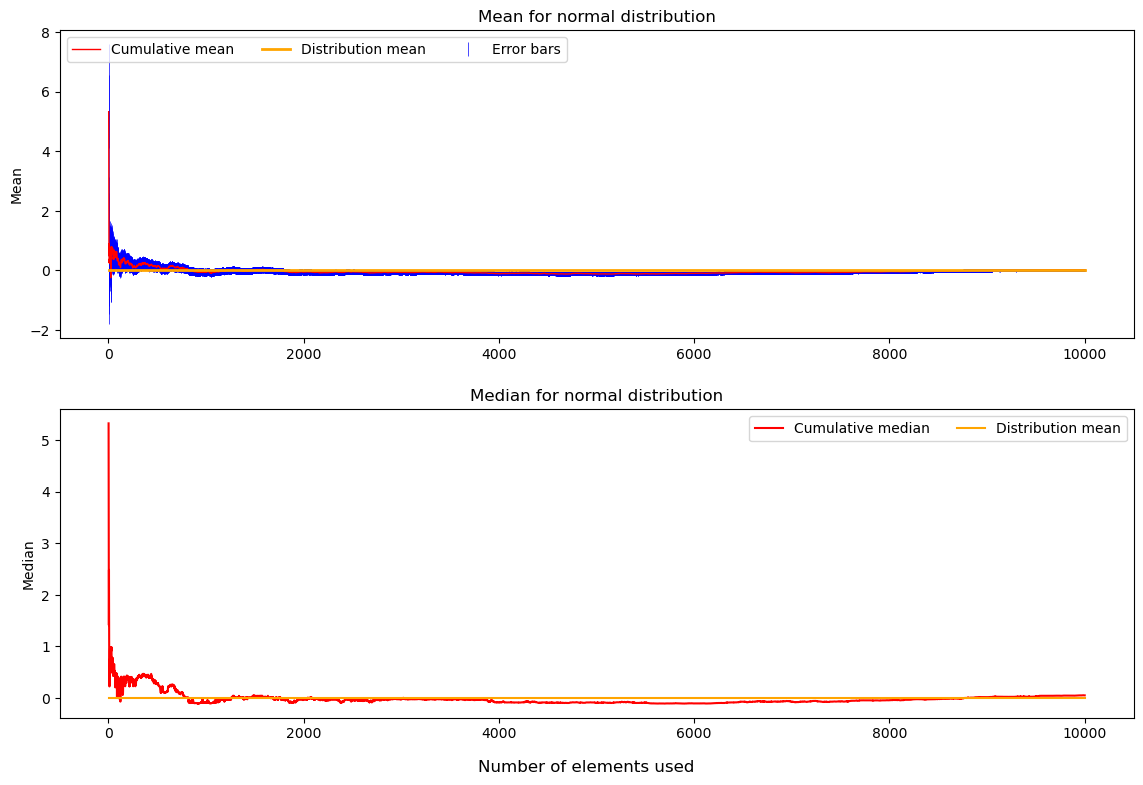

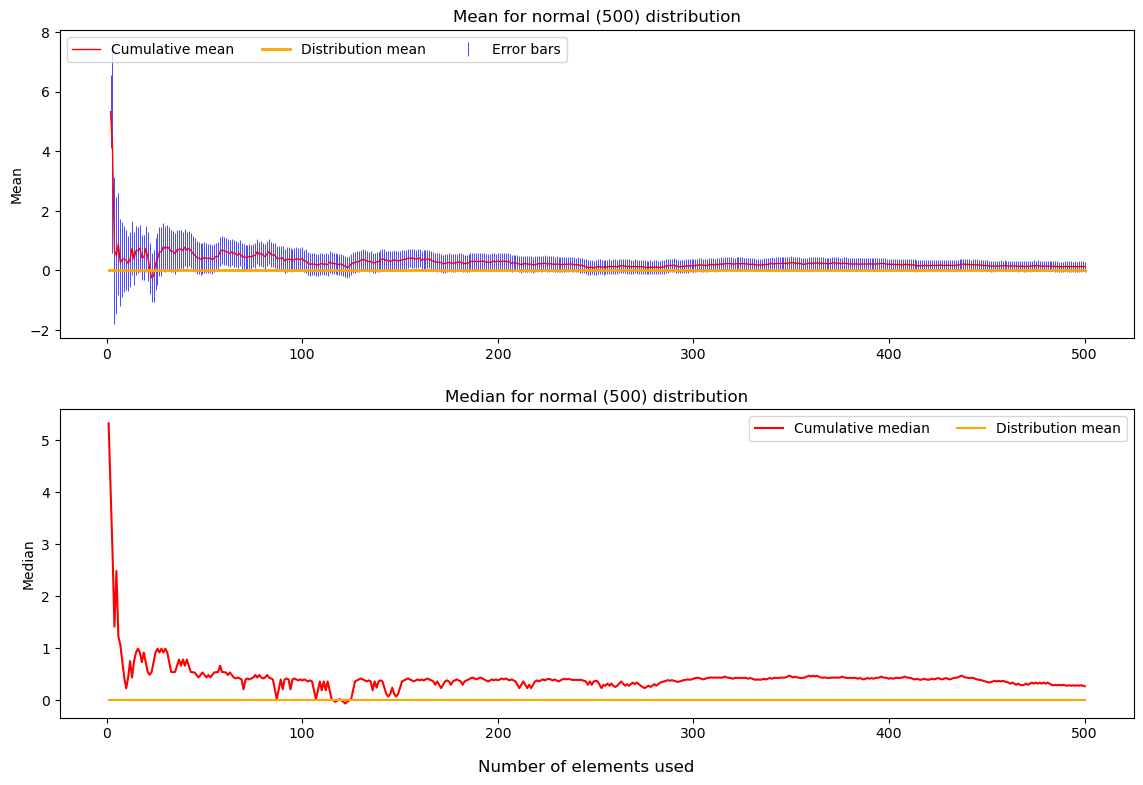

In [23]:
# Plot normal
create_plot(normal, mean=normal_mu, median=normal_mu, n=n, name="normal")
create_plot(normal[:n2], mean=normal_mu, median=normal_mu, n=n2, name="normal (500)")

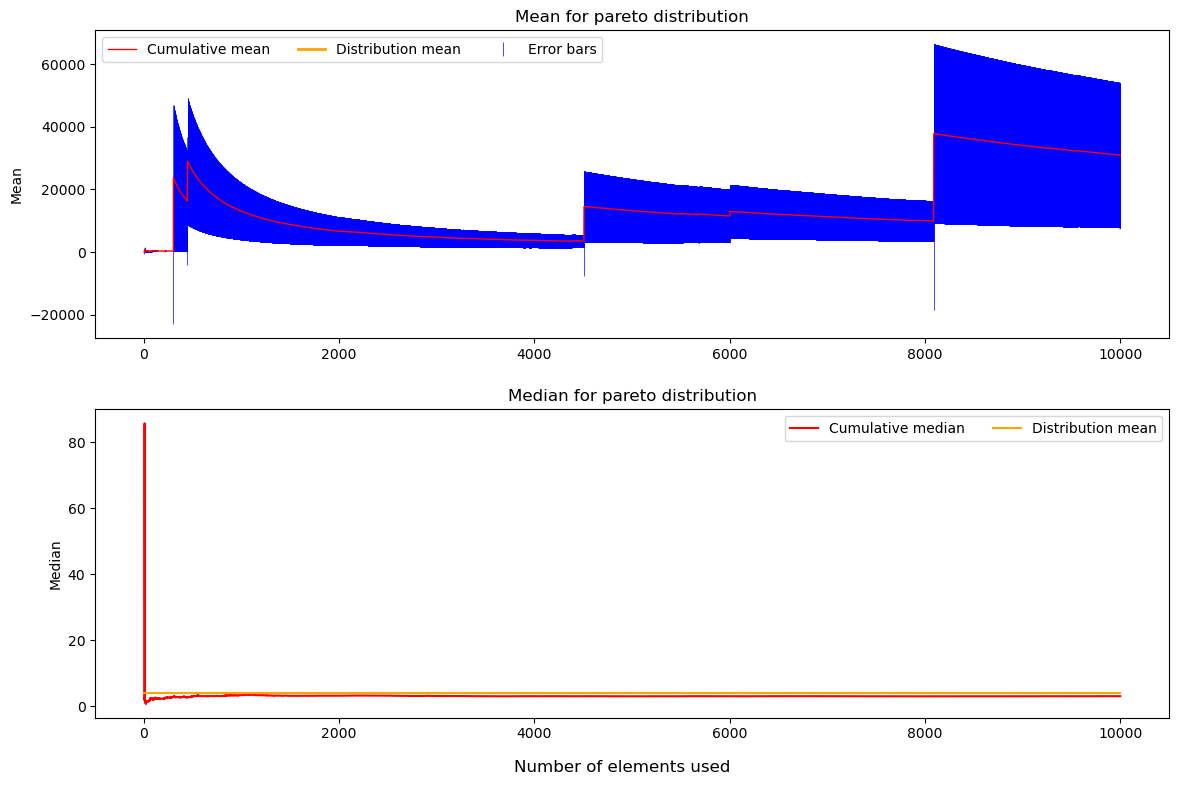

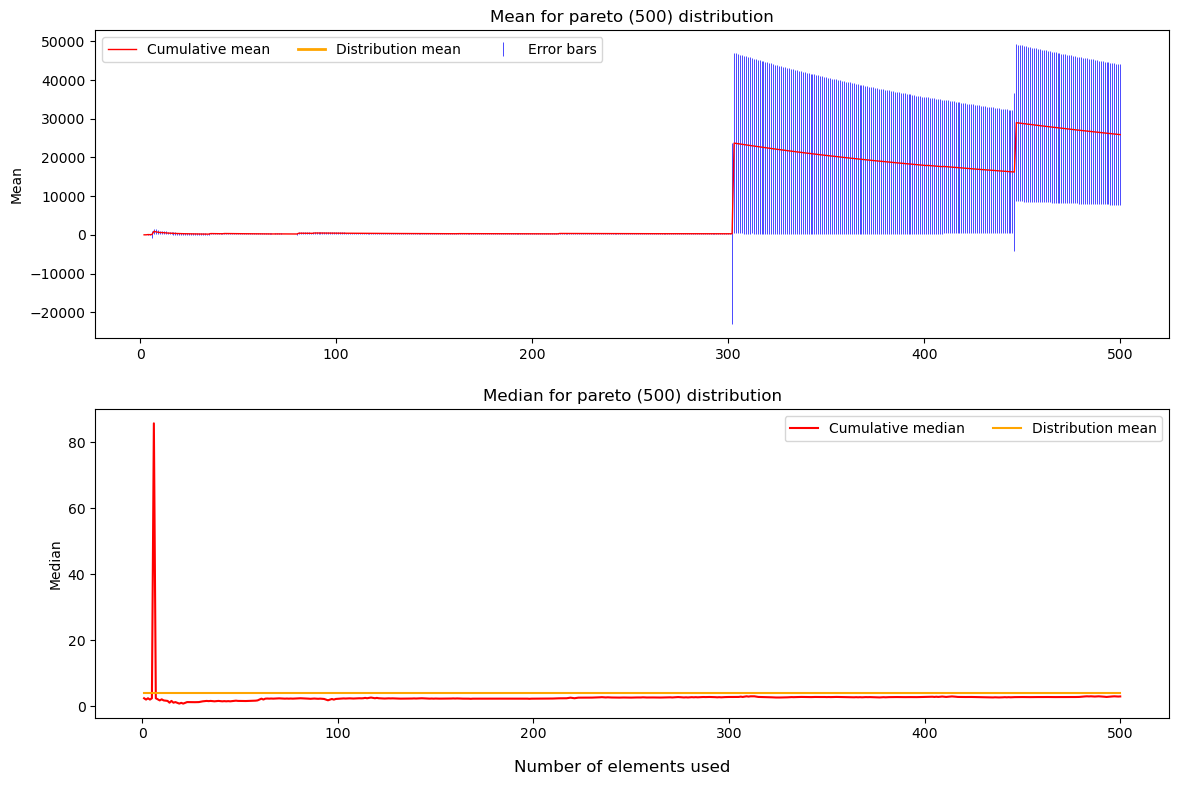

In [24]:
# Plot pareto 
create_plot(pareto, mean=pareto_mean, median=pareto_median, n=n, name="pareto")
create_plot(pareto[:n2], mean=pareto_mean, median=pareto_median, n=n2, name="pareto (500)")

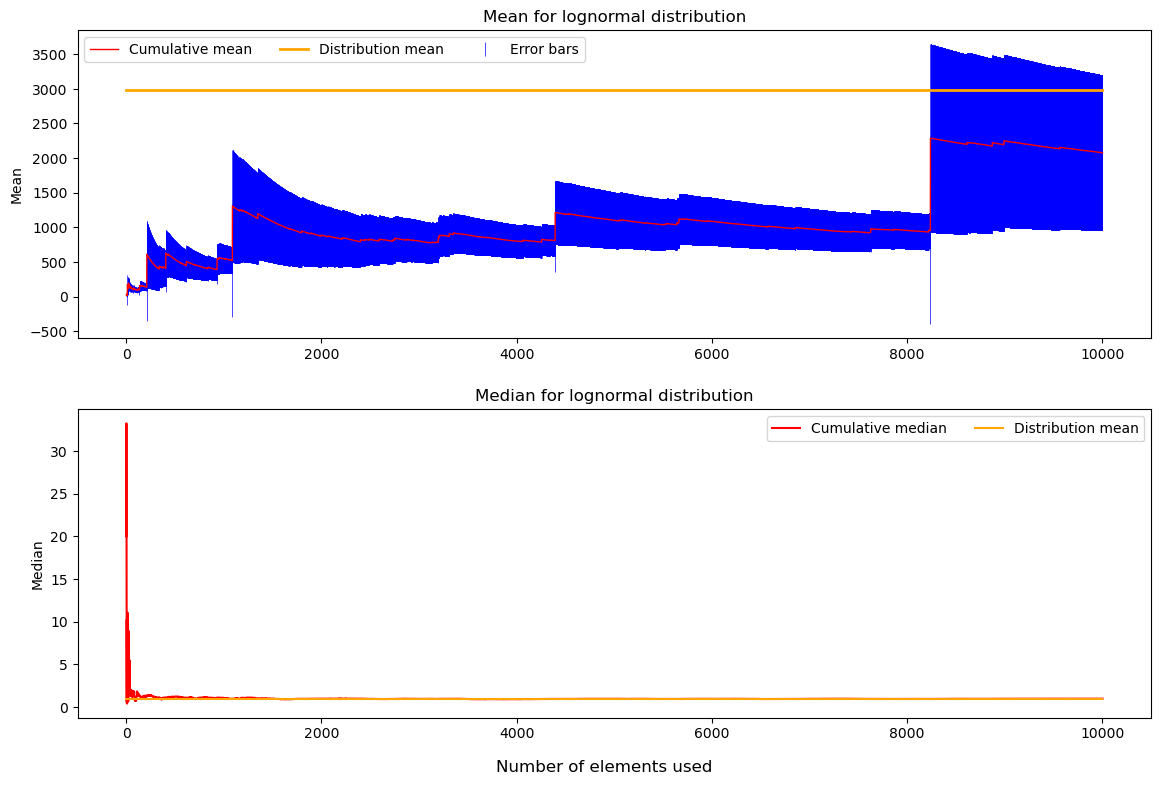

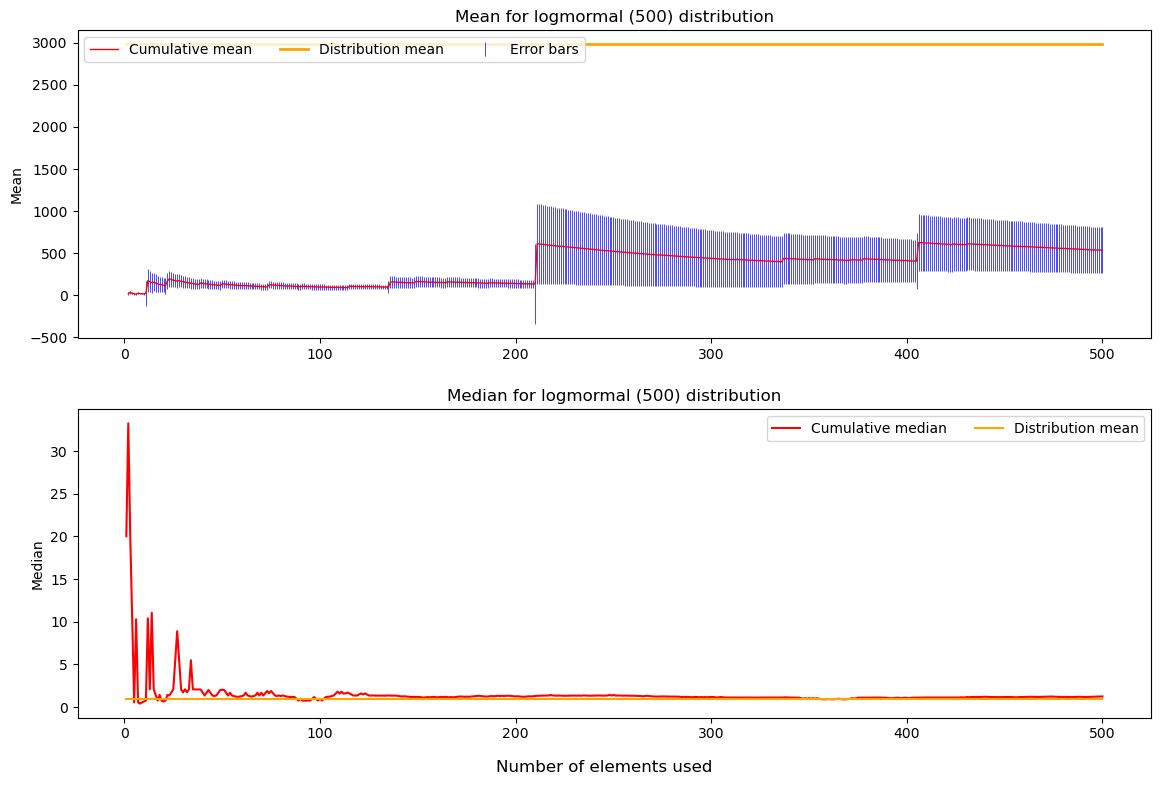

In [25]:
# Plot lognormal
create_plot(lognormal, mean=lognormal_mean, median=lognormal_median, n=n, name="lognormal")
create_plot(lognormal[:n2], mean=lognormal_mean, median=lognormal_median, n=n2, name="logmormal (500)")


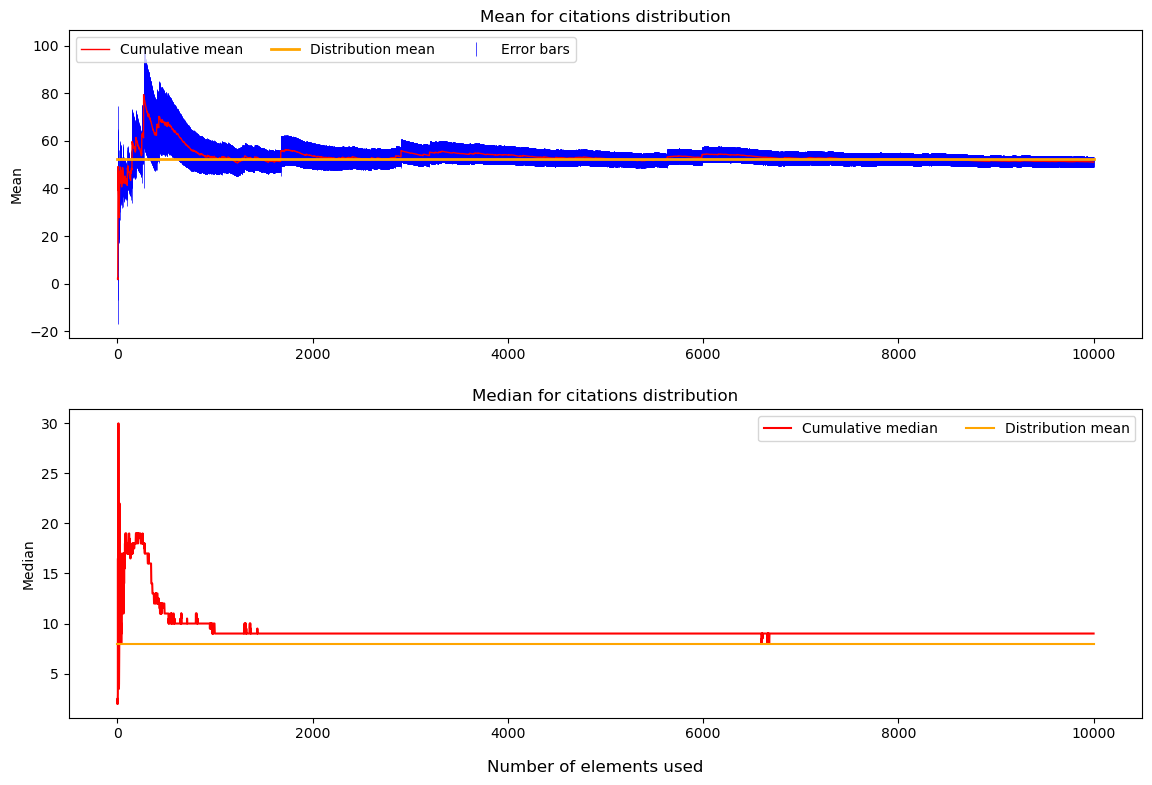

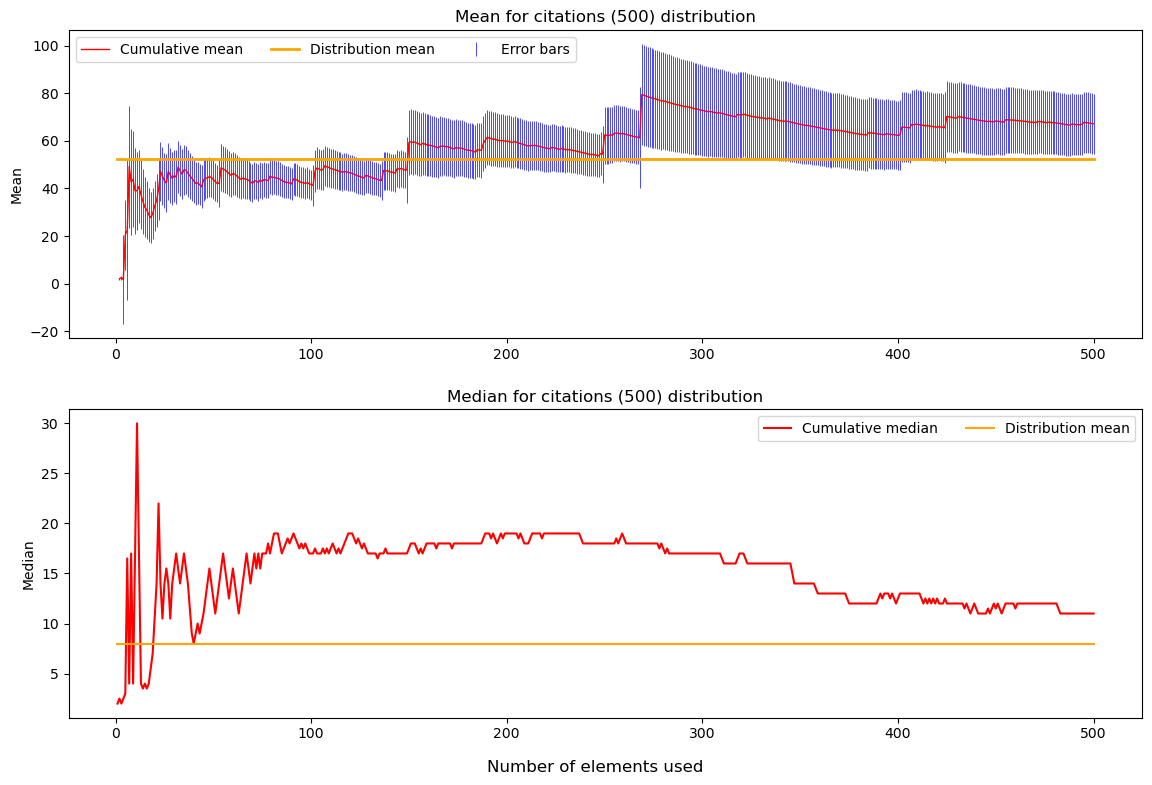

In [27]:
# Sample citation counts from the 2009 computational social science papers
df_papers = pd.read_csv("df_paper.csv")
mask_2009 = df_papers['year'] == 2009
citationCount_all = np.array(df_papers['citationCount'][mask_2009])
citations_mean = np.mean(citationCount_all)
citations_median = np.median(citationCount_all)
sampledCitationCount = np.random.choice(citationCount_all, n)

create_plot(sampledCitationCount, mean=citations_mean, median=citations_median, n=n, name="citations")
create_plot(sampledCitationCount[:n2], mean=citations_mean, median=citations_median, n=n2, name="citations (500)")

TypeError: 'Text' object is not callable

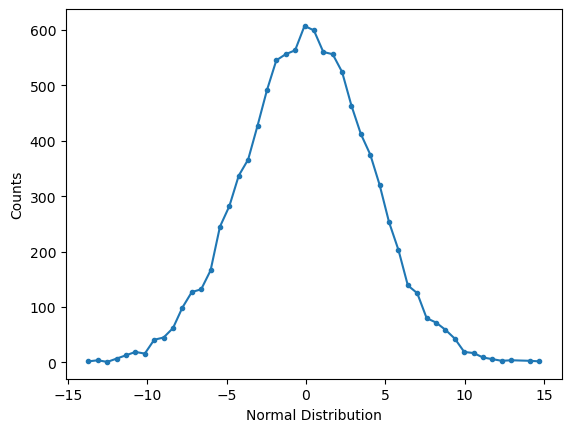

In [28]:
# Plot histograms of all 4 distributions 

# Plot normal
plot_hist(normal, name="Normal Distribution", remove_empty = True)
plot_hist(normal, name="Normal Distribution", remove_empty = True, log = True)

# pareto
plot_hist(pareto, name="Pareto Distribution", remove_empty = True)
plot_hist(pareto, name="Pareto Distribution", remove_empty = True, log = True)

# Lognormal
plot_hist(lognormal, name="Lognormal Distribution", remove_empty = True)
plot_hist(lognormal, name="Lognormal Distribution", remove_empty = True, log = True)

# Citation counts 
plot_hist(sampledCitationCount, name="Citation Count Distribution", remove_empty = True)
plot_hist(sampledCitationCount, name="Citation Count Distribution", remove_empty = True, log = True)

### Conclusion 

#### 3.1) 
Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?

From this experimental setup we see that the Guassian distributions empirical average converges to the true mean value with less values, while the convergence for the LogNormal and Pareto distributions seem to require more values, and is disrupted by sudden realisations which push the empirical average towards much larger values. This happens recurringly.
This is more obvious for the Pareto distribution, which is also what we learned in class - the Pareto distributions mean value is defined as infinity for $\alpha < 1$, since no single value can be infinite we should expect that the empirical average will never converge to anything because we will always get a realisation from the heavy tail that is much bigger than all previous values combined that it can inflate the mean arbitrarily much.
The Pareto distribution is extreme compared to the LogNormal that actually has a defined mean value, but both shows how the heavy tails dominate the empirical average value. 


#### 3.2) 
Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?

In this experiment it is clear that even though the mean value takes a very long time to converge, the median converges quite quickly for both of the heavy tailed distributions. This is expected when there is at least a moderate amount of probability mass around the true distribution median, because statistically half of the realisations are larger and half are lower. In other words the tail/outliers of the distribution do not significantly affect the empirical median. 

The empirical mean and median are of similar note for a Guassian distribution because they converge to the same - they are both central estimators for the Guassian distribution. 
However, for the skewed/heavy tailed distributions the mean takes quite a while to converge (and in the Pareto distributions case it does not), which makes the median a more informative statistic. This is especially true if we only have few samples. 

#### 3.3) 
Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?

In our case we see that the empirical mean of the citation counts does converge, but has some jumps like the heavy tailed distributions. To investigate further if it indeed follows a heavy tailed distribution we plot the histogram of all 4 distributions. Here we see that it does not follow a something very close to a straight line as the Pareto and LogNormal distribution, but it is definitly more heavy tailed than the Guassian distribution. 

For this reason the median is likly a more informative statistic than the mean value. Because there are not many jumps in the empirical average plot, we believe that this empirical average is a fairly good estimator of the mean. (Note: we don't actually know the distribution mean, the closest we can get is taking the average of ALL samples from 2009)

#### 3.4) 
What do you think are the main take-home message of this exercise?

We believe that the lesson to learn is that statistics do not uniquely define all distributions. Statistics are usefull tools to help describe and compare distributions, but if the distribution is unknown it is a good idea to examine it further than just looking at a few statistics.   
